# CNN first model

Here I use a network doing a CNN over the input. The model architecture is a CNN of the local features. These then get pooled down to the number of channels, which is then fed into a dense layer.

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from cnn_network import SimpleCNN
import pandas as pd

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cnn_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

########### Select Indexes TCR DATA ############

# Full model
#idx = np.arange(420)

# peptide + TCR
#idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
#idx = np.arange(192)


########### Select Indexes CDR Data ############

# Full model
# idx = np.arange(248)

# Peptide + All CDRS
idx = np.arange(179,248)

########### Select Features ###########

# All features
#local_features = np.arange(27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])


# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()

# slicing sequence dimension
train_data.slice_data(idx)
val_data.slice_data(idx)
test_data.slice_data(idx)

train_data.to_blossum()
val_data.to_blossum()
test_data.to_blossum()

input_len = train_data.data.shape[2]


In [6]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [7]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [8]:
train_data.data.shape

(4174, 54, 69)

In [9]:
#Hyperparameters
epochs = 100
patience = 20
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
weight_decay = 0.0005

# Layer parameters
cnn_channels = 30
hidden_neurons = 64
dropout = 0.4
cnn_kernel = 3

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
stopper = EarlyStopping(patience, model_name, model_path)


In [10]:
net = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.to(device)
print(net)
print("Using Device:", device)
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=weight_decay,
    amsgrad=True
)

SimpleCNN(
  (cdr1a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (cdr2a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (cdr3a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (cdr1b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (cdr2b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (cdr3b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (pep_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=same)
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (max_pool_index): AdaptiveMaxPool1d(output_size=1)
  (dense1): Linear(in_features=210, out_features=64, bias=True)
  (dense_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn_dense): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_start): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [11]:
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [12]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.2826380296186967 Train MCC: 0.17744122382406433 Train AUC: 0.6238975175453434
Validation loss: 0.24128792683283487 Validation MCC: 0.24175219837412287 Validation AUC: 0.7231751074268236
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.24257261102849786 Train MCC: 0.24762214043626316 Train AUC: 0.6851239021137756
Validation loss: 0.23233423630396524 Validation MCC: 0.2257524652128271 Validation AUC: 0.7271245060411256
Validation loss decreased. Counter reset
Epoch: 3
Train loss: 0.23164424029263583 Train MCC: 0.26966602628033975 Train AUC: 0.7150392334223163
Validation loss: 0.23459486166636148 Validation MCC: 0.24048568621574545 Validation AUC: 0.729933169267407
Early Stopping Counter: 1 out of 20
Epoch: 4
Train loss: 0.22782571388013434 Train MCC: 0.3182636699087577 Train AUC: 0.7289412981715582
Validation loss: 0.22451045115788779 Validation MCC: 0.27885878186867746 Validation AUC: 0.7407065287785723
Validation loss decreased. Counter reset
Epoch

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

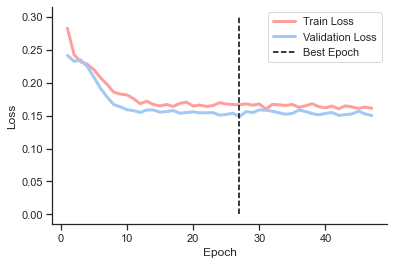

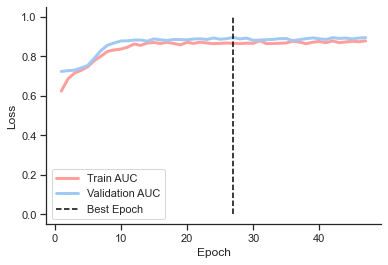

In [13]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [14]:
final_model = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
final_model.load_state_dict(torch.load(model_path + model_name))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [15]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.1335902214050293
MCC: 0.6666467126701472
Confussion Matrix:
 [[2784  348]
 [ 202  840]] 

Evaluation on Validation Data:
Loss: 0.14840089281400046
MCC: 0.6215738174114026
Confussion Matrix:
 [[1021  128]
 [  96  287]] 

Evaluation on Test Data:
Loss: 0.1603468844765111
MCC: 0.5942324501455727
Confussion Matrix:
 [[804 102]
 [ 85 216]] 



Text(0.5, 1.0, 'Test Data')

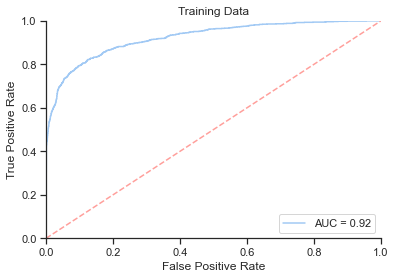

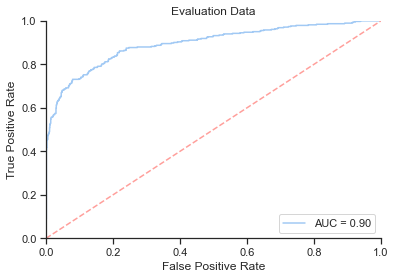

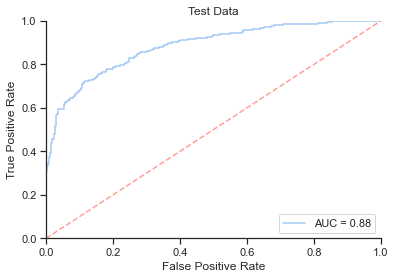

In [16]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")
